# HemoCell Visualizations for the article

In [17]:
import numpy as np
import pandas as pd

from scipy.stats import multivariate_normal
from scipy.stats import kstest

import tqdm

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from lxml import etree

from SALib.sample import saltelli
from SALib.analyze import sobol

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel

import statsmodels.api as sm

from local_config import *

print(plt.style.available)
#plt.style.use("ggplot")

figpath = "/home/kevin/master_project/figures_for_paper"
figformat = "jpeg"
figdpi = 500

#titlefontsize = 24
#axisfontsize = 24
#labelfontsize = 20

plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"
#plt.rcParams["axes.titleweight"] = "bold"

plt.rcParams['figure.dpi'] = figdpi

plt.rcParams["font.family"] = "Arial"

['seaborn-muted', 'seaborn-deep', 'seaborn-ticks', 'seaborn-dark', 'dark_background', 'seaborn-pastel', 'seaborn-darkgrid', 'seaborn-colorblind', 'tableau-colorblind10', 'fivethirtyeight', 'seaborn-talk', 'grayscale', '_classic_test', 'seaborn', 'seaborn-white', 'fast', 'bmh', 'ggplot', 'classic', 'seaborn-poster', 'seaborn-dark-palette', 'seaborn-paper', 'Solarize_Light2', 'seaborn-notebook', 'seaborn-whitegrid', 'seaborn-bright']


In [18]:
mode = "visc"
cellHealth = "healthy"

HC_lmax = 1
GP_lmax = 1

HC_nburn = 0
GP_nburn = 10

HC_nsamples = 1000
GP_nsamples = 10000

gpType = "single"
isotropic = False

gpModelType = gpType + "_GP_"
if isotropic:
    gpModelType = gpModelType + "isotropic"
else:
    gpModelType = gpModelType + "anisotropic"


# Set error types per cell type for the GP model
healthyErrType = "EL_error"
treatedErrType = "EL_error"
    

if cellHealth == "healthy":
    errType = healthyErrType
elif cellHealth == "treated":
    errType = treatedErrType


if cellHealth == "healthy":
    imin = 2
    imax = 8
    
    HC_violin_color = "green"
    HC_cmap = "Greens"
    
    GP_violin_color = "red"
    GP_cmap = "Reds"
elif cellHealth == "treated":
    imin = 4
    imax = 10
    
    HC_violin_color = "orange"
    HC_cmap = "Oranges"
    
    GP_violin_color = "blue"
    GP_cmap = "Blues"

# Load results from posterior sampling

# HemoCell model
HC_df = pd.read_csv("%s/TMCMC_hemocell_%s_%s_samples_%s_%i_%i_lmax_%s_nburn_%i_nsamples_%i.csv" % 
                    (outputpath,cellHealth,errType,mode,imin,imax,HC_lmax,HC_nburn,HC_nsamples),sep=";")

HC_qoi = np.load("%s/TMCMC_hemocell_%s_%s_qoi_%s_%i_%i_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                 (outputpath,cellHealth,errType,mode,imin,imax,HC_lmax,HC_nburn,HC_nsamples))

HC_c_err = np.load("%s/TMCMC_hemocell_%s_%s_c_err_%s_%i_%i_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                   (outputpath,cellHealth,errType,mode,imin,imax,HC_lmax,HC_nburn,HC_nsamples))

# Gaussian Process model
GP_df = pd.read_csv("%s/TMCMC_%s_%s_%s_samples_%s_%i_%i_lmax_%s_nburn_%i_nsamples_%i.csv" % 
                    (outputpath,gpModelType,cellHealth,errType,mode,imin,imax,GP_lmax,GP_nburn,GP_nsamples),sep=";")

GP_qoi = np.load("%s/TMCMC_%s_%s_%s_qoi_%s_%i_%i_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                 (outputpath,gpModelType,cellHealth,errType,mode,imin,imax,GP_lmax,GP_nburn,GP_nsamples))

GP_c_err = np.load("%s/TMCMC_%s_%s_%s_c_err_%s_%i_%i_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                   (outputpath,gpModelType,cellHealth,errType,mode,imin,imax,GP_lmax,GP_nburn,GP_nsamples))

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")

if cellHealth == "treated":
    stress,el,el_err = data.loc[data["Treatment"] == 0.5].values[imin:imax,[1,2,3]].T
elif cellHealth == "healthy":
    stress,el,el_err = data.loc[data["Treatment"] == 0].values[imin:imax,[1,2,3]].T
    
if errType == "no_EL_error":
    el_err = np.zeros(el.shape)

# Parameter names
params = ["kLink","kBend"]

if mode == "visc":
    params.append("viscosityRatio")

#params = params + ["err"]
    
    
names = {"kLink":r"$\kappa_l$","kBend":r"$\kappa_b$",
         "viscosityRatio":r"$\Lambda$","err":r"$\sigma^m$",
         "shearrate":r"$\dot{\gamma}$ [$s^{-1}$]"}

# Data visualizations

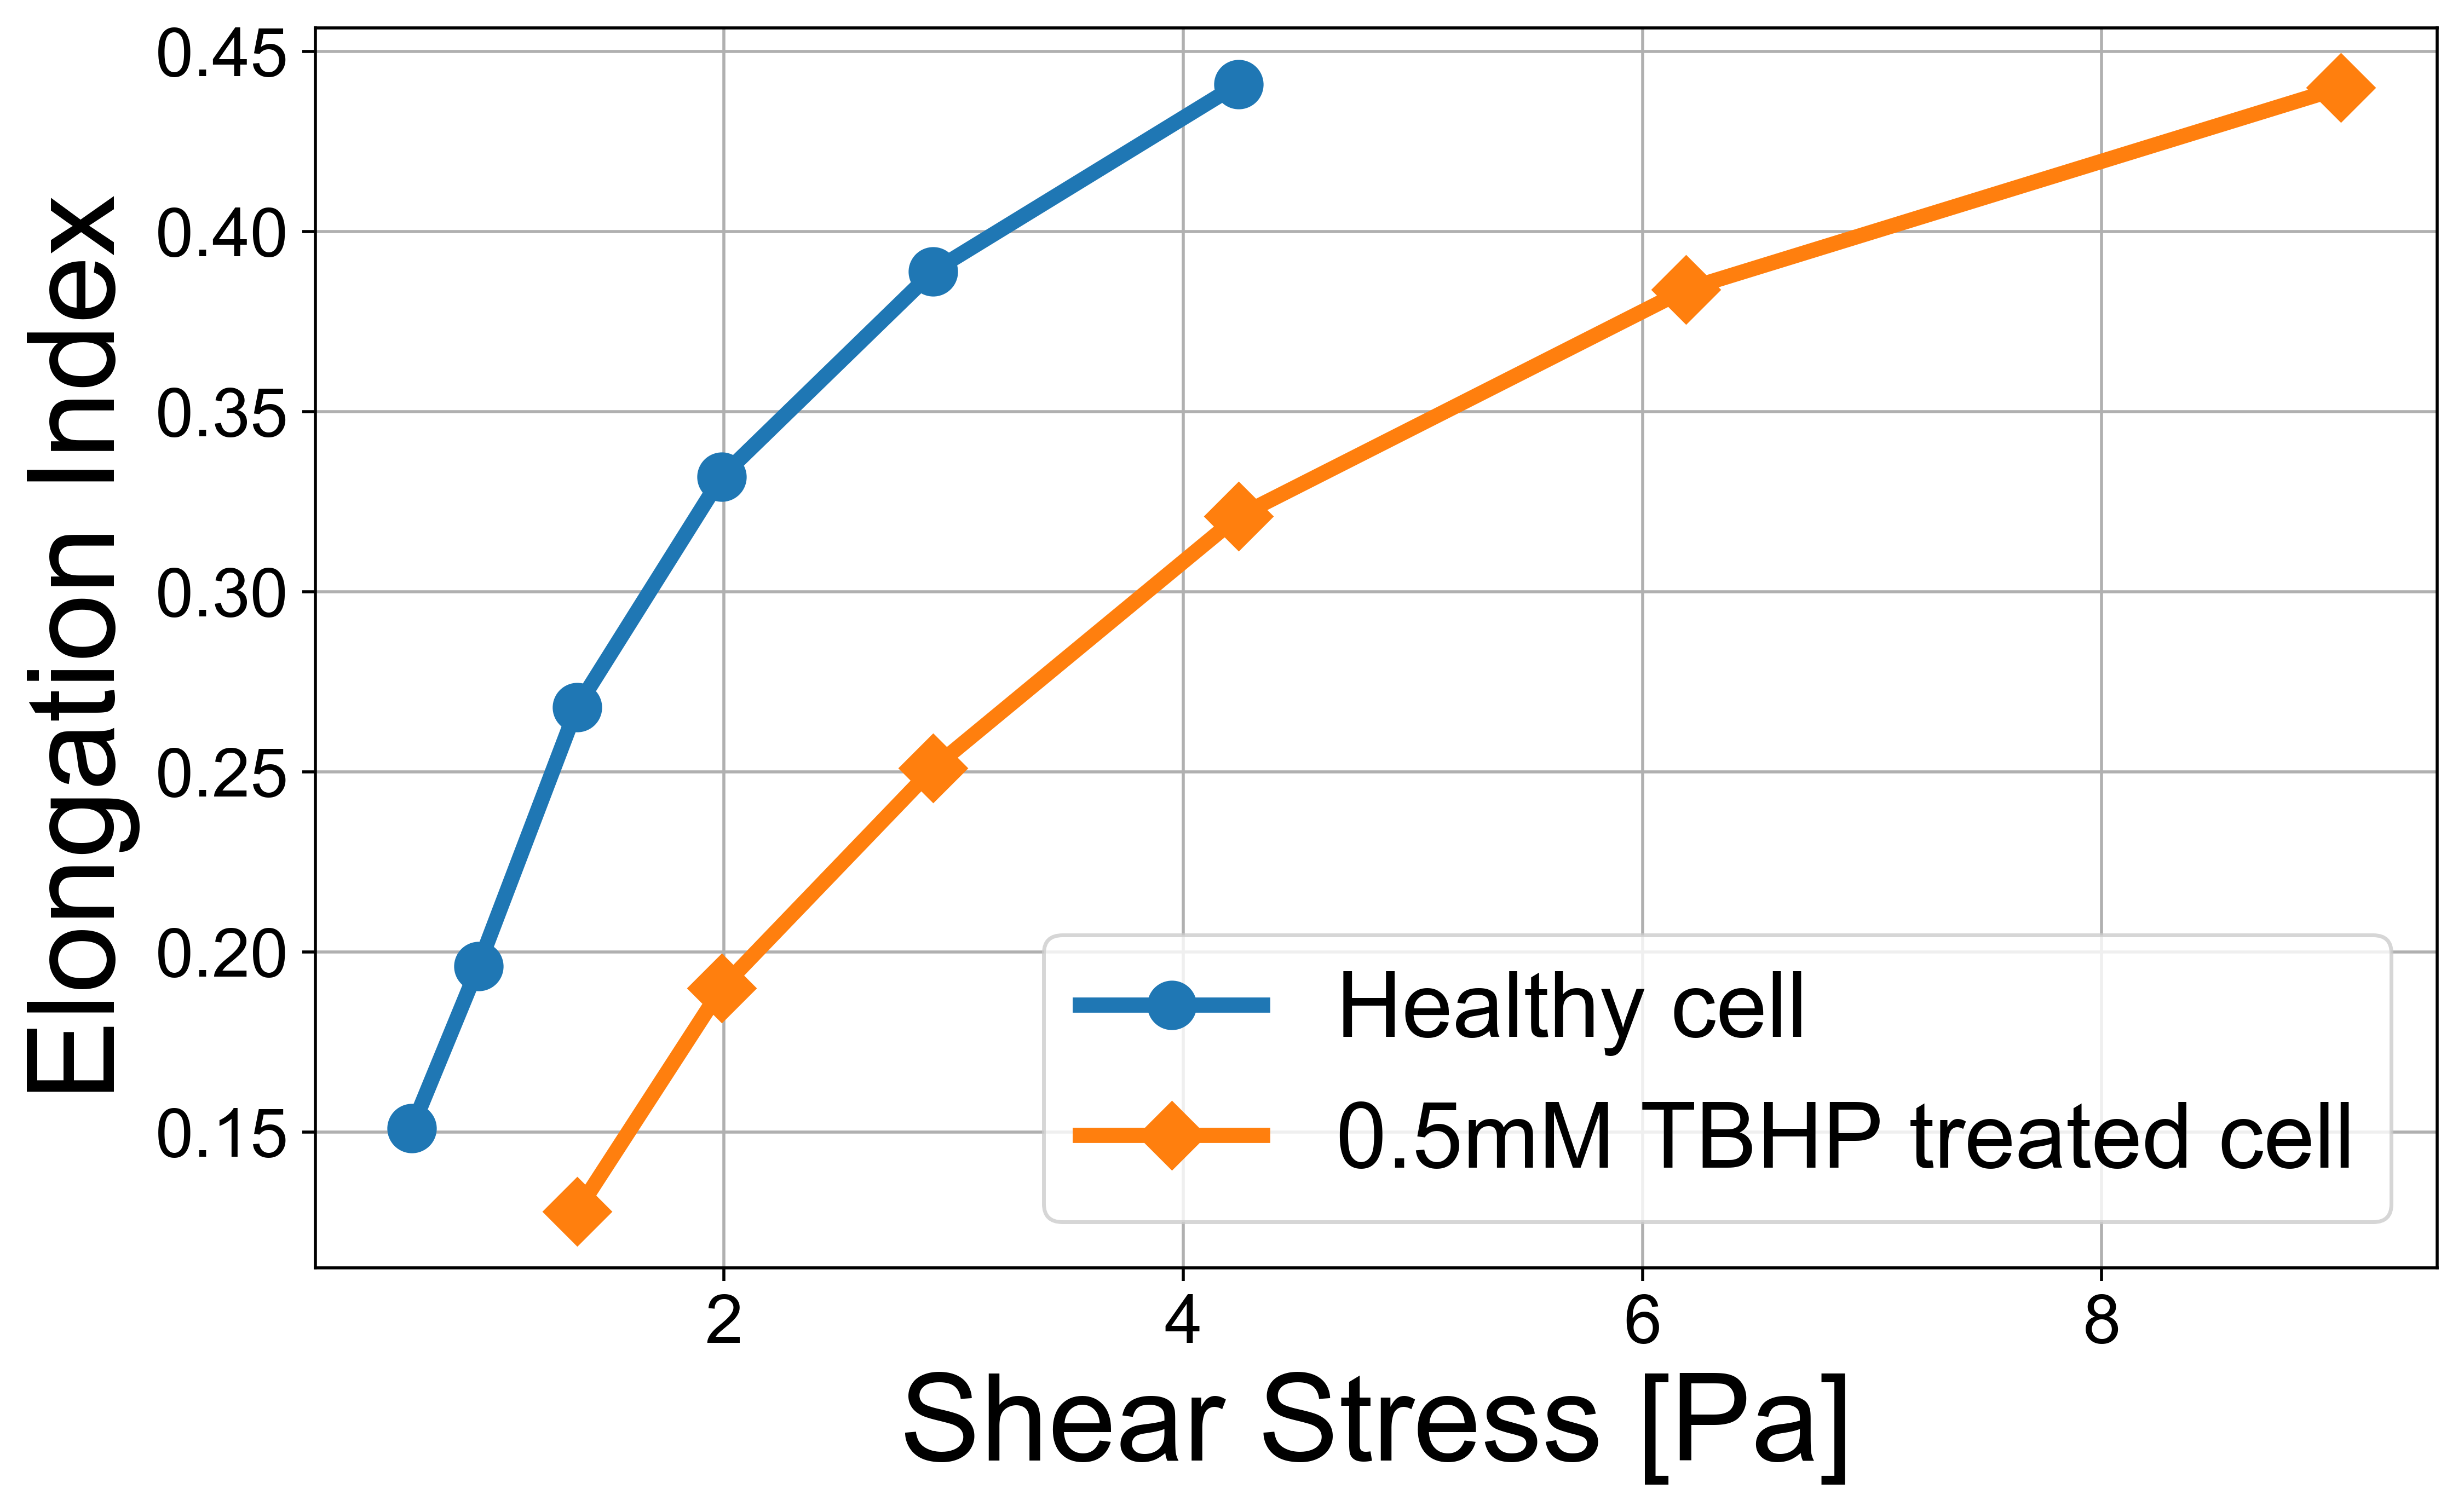

In [140]:
full_stress,el_healthy,el_healthy_err = data.loc[data["Treatment"] == 0].values[0:10,[1,2,3]].T
el_treated,el_treated_err = data.loc[data["Treatment"] == 0.5].values[0:10,[2,3]].T

dx = full_stress[1:] - full_stress[:-1]
dy_healthy = el_healthy[1:] - el_healthy[:-1]
dy_treated = el_treated[1:] - el_treated[:-1]

x = (full_stress[:-1] + full_stress[1:]) / 2

plt.figure(figsize=(10,6))

plt.xlabel("Shear Stress [Pa]",fontsize=32)
plt.ylabel("Elongation Index",fontsize=32)
plt.grid(True)
plt.plot(full_stress[2:8],el_healthy[2:8],"o-",linewidth=4,markersize=12,label="Healthy cell")
plt.plot(full_stress[4:10],el_treated[4:10],"D-",linewidth=4,markersize=12,label="0.5mM TBHP treated cell")

plt.legend(fontsize=24)
plt.savefig("%s/ektacytometry_data.%s" % (figpath,figformat),dpi=figdpi,bbox_inches="tight")

# Model performance comparison

Shear stress: 0.640000, Shear rate: 567.627494

249 µs ± 33.7 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Shear stress: 0.930000, Shear rate: 824.833703

253 µs ± 37.4 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Shear stress: 1.360000, Shear rate: 1206.208426

248 µs ± 12.5 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Shear stress: 1.990000, Shear rate: 1764.966741

254 µs ± 21.6 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Shear stress: 2.910000, Shear rate: 2580.931264

249 µs ± 11.9 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Shear stress: 4.240000, Shear rate: 3760.532151

252 µs ± 13 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Shear stress: 6.190000, Shear rate: 5490.022173

254 µs ± 31 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Shear stress: 9.040000, Shear rate: 8017.738359

244 µs ± 10.9 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

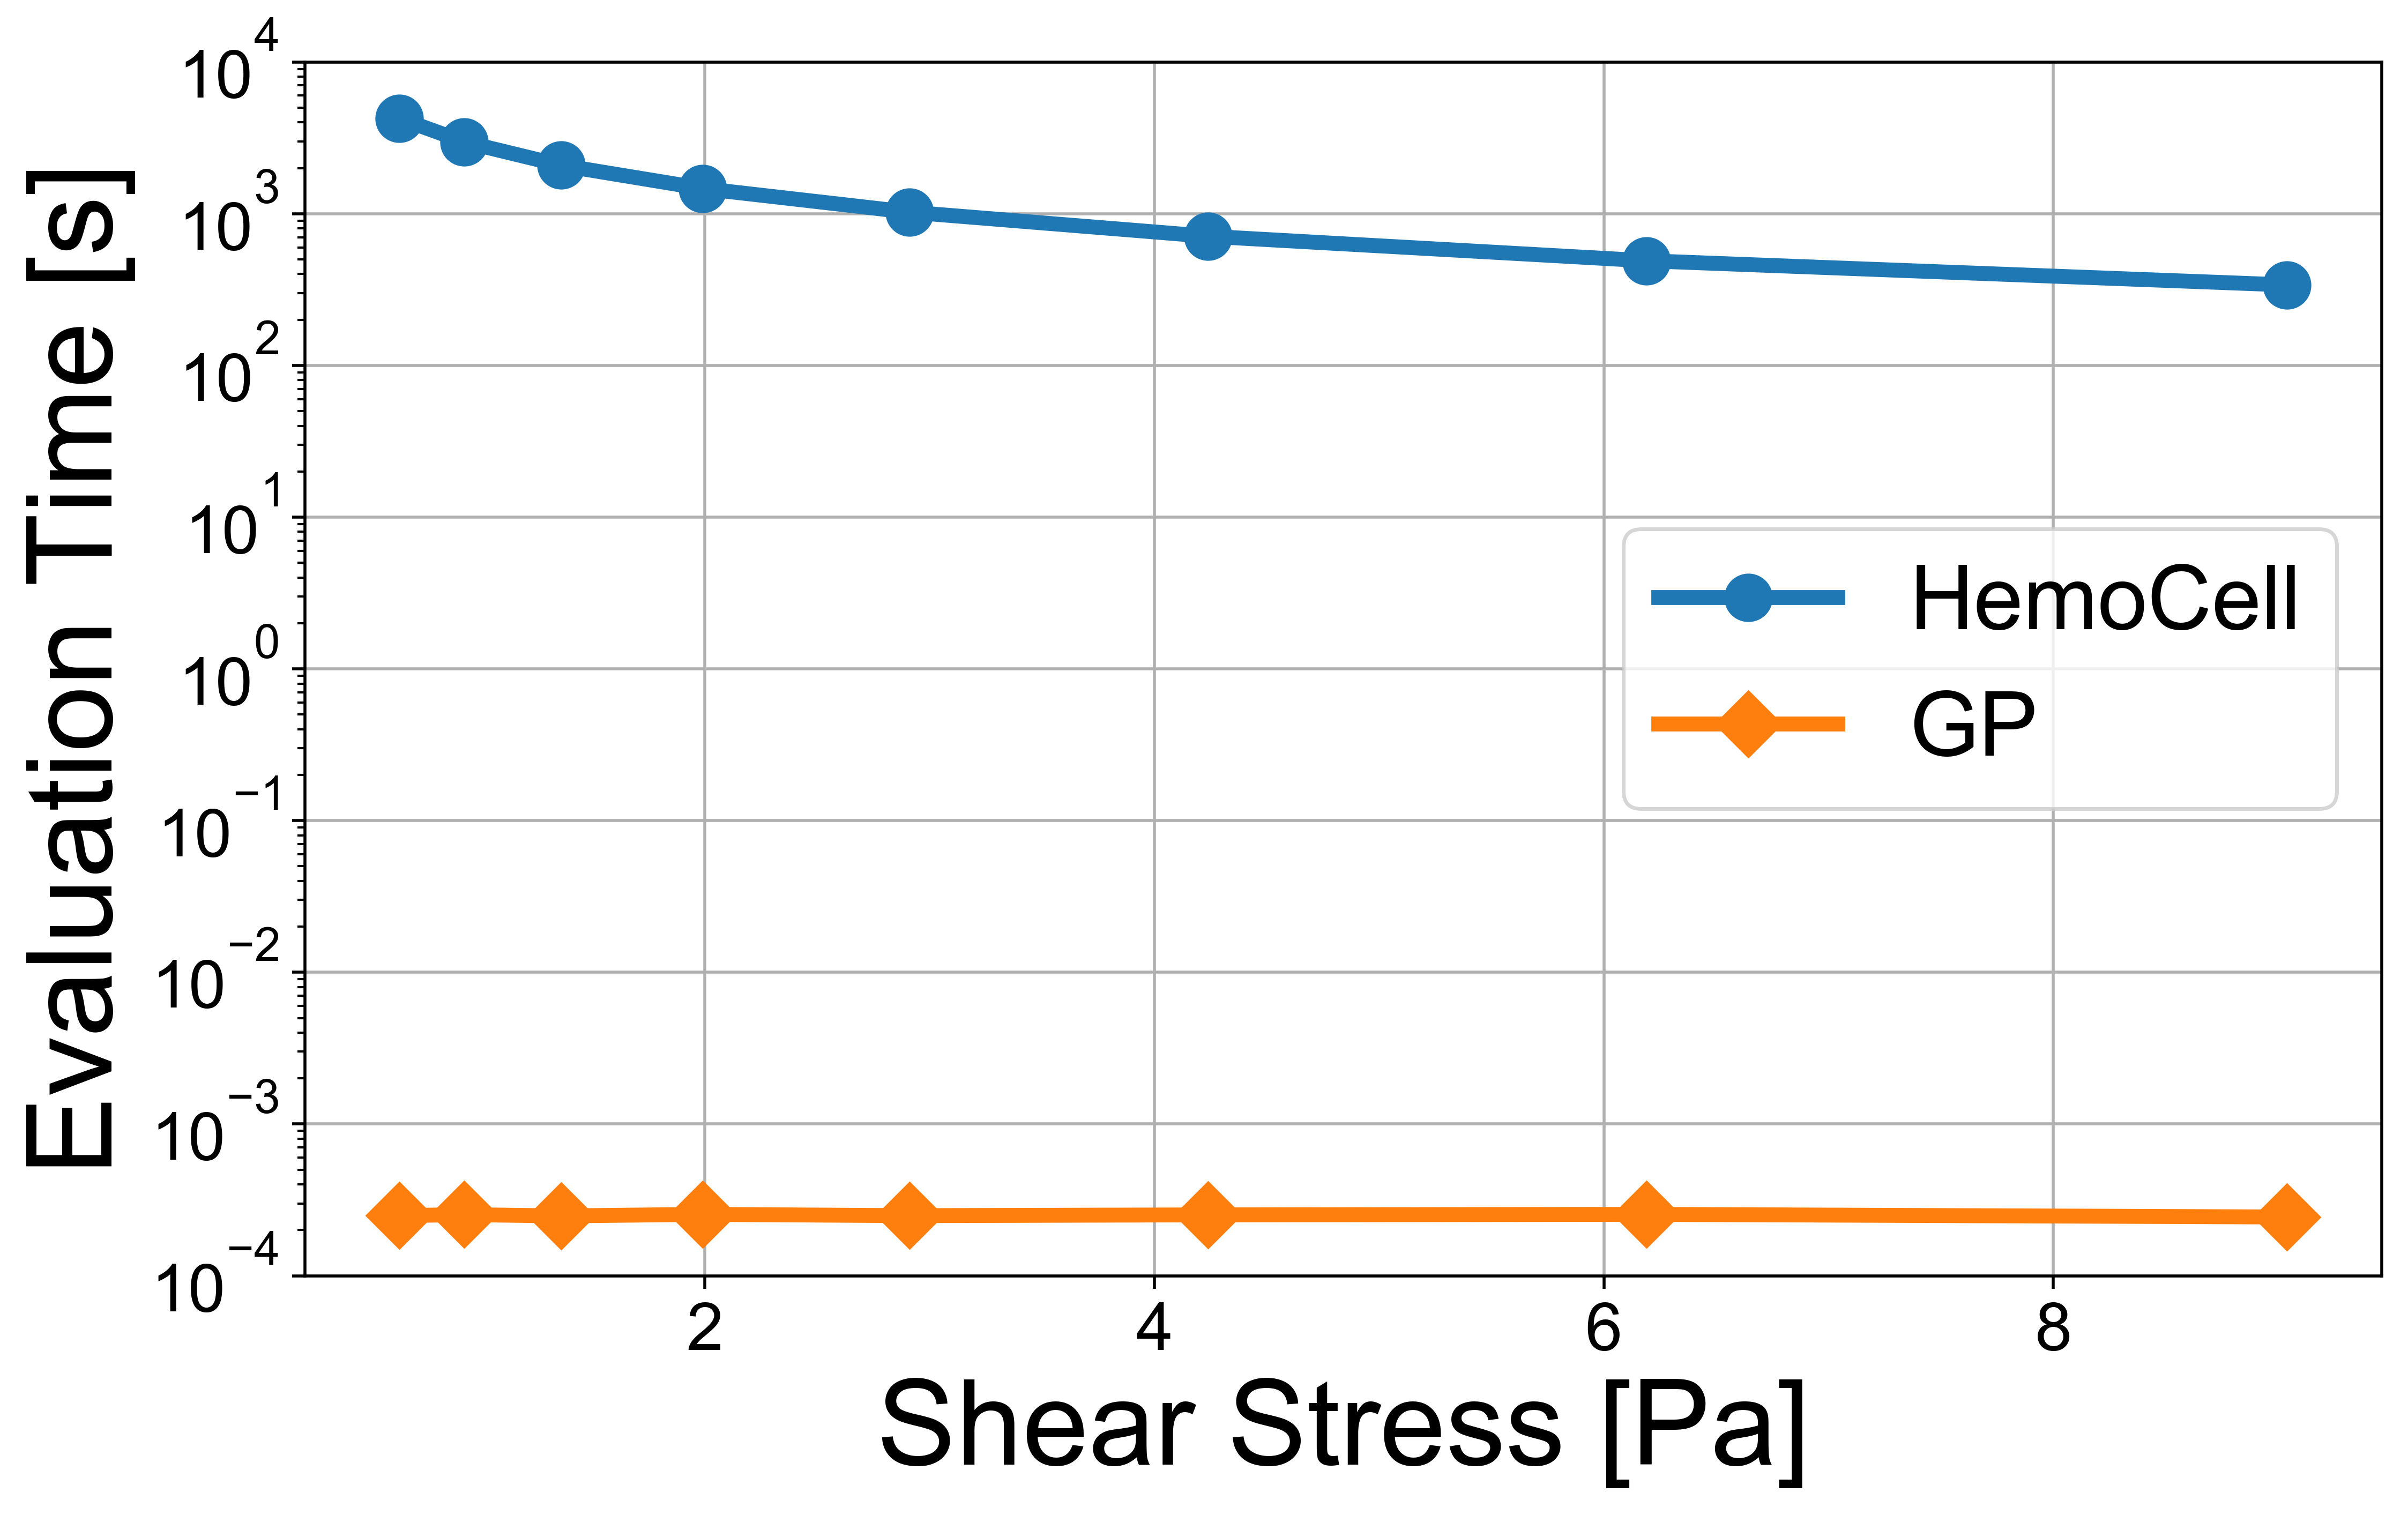

In [141]:
HC_performance = {0.64:4259.28,
                  0.93:2975.48,
                  1.36:2085.16, 
                  1.99:1465.24, 
                  2.91:1023.44, 
                  4.24:709.67, 
                  6.19:489.48, 
                  9.04:339.02
                 }

GP_performance = {0.64:249e-6,
                  0.93:253e-6,
                  1.36:248e-6, 
                  1.99:254e-6, 
                  2.91:249e-6, 
                  4.24:252e-6, 
                  6.19:254e-6, 
                  9.04:244e-6
                 }

GP_performance_std = {0.64:33.7e-6,
                      0.93:37.4e-6,
                      1.36:12.5e-6, 
                      1.99:21.6e-6, 
                      2.91:11.9e-6, 
                      4.24:13e-6, 
                      6.19:31e-6, 
                      9.04:10.9e-6}

plt.figure(figsize=(10,6))
plt.xlabel("Shear Stress [Pa]",fontsize=32)
plt.ylabel("Evaluation Time [s]",fontsize=32)

plt.yscale("log")
plt.ylim(10**-4,10**4)
plt.yticks(10**np.arange(-4,5,dtype=np.float))
plt.grid(True)

plt.plot(list(HC_performance.keys()),list(HC_performance.values()),"o-",
         linewidth=4,markersize=12,label="HemoCell")

plt.plot(list(GP_performance.keys()),list(GP_performance.values()),"D-",
         linewidth=4,markersize=12,label="GP")

plt.legend(fontsize=24)
plt.savefig("%s/performance_comparison.%s" % (figpath,figformat),dpi=figdpi,bbox_inches="tight")

# UQ visualizations

## 1D Marginalized figures (HemoCell & GP together)

HC KDE maximum of kLink: 37.58449613380863
GP KDE maximum of kLink: 36.815552050875525
HC KDE maximum of kBend: 336.13146316821536
GP KDE maximum of kBend: 200.9349546873369
HC KDE maximum of viscosityRatio: 5.2169589566334835
GP KDE maximum of viscosityRatio: 5.235915287729053
HC KDE maximum of err: 0.015340349503848282
GP KDE maximum of err: 0.007836898948935151


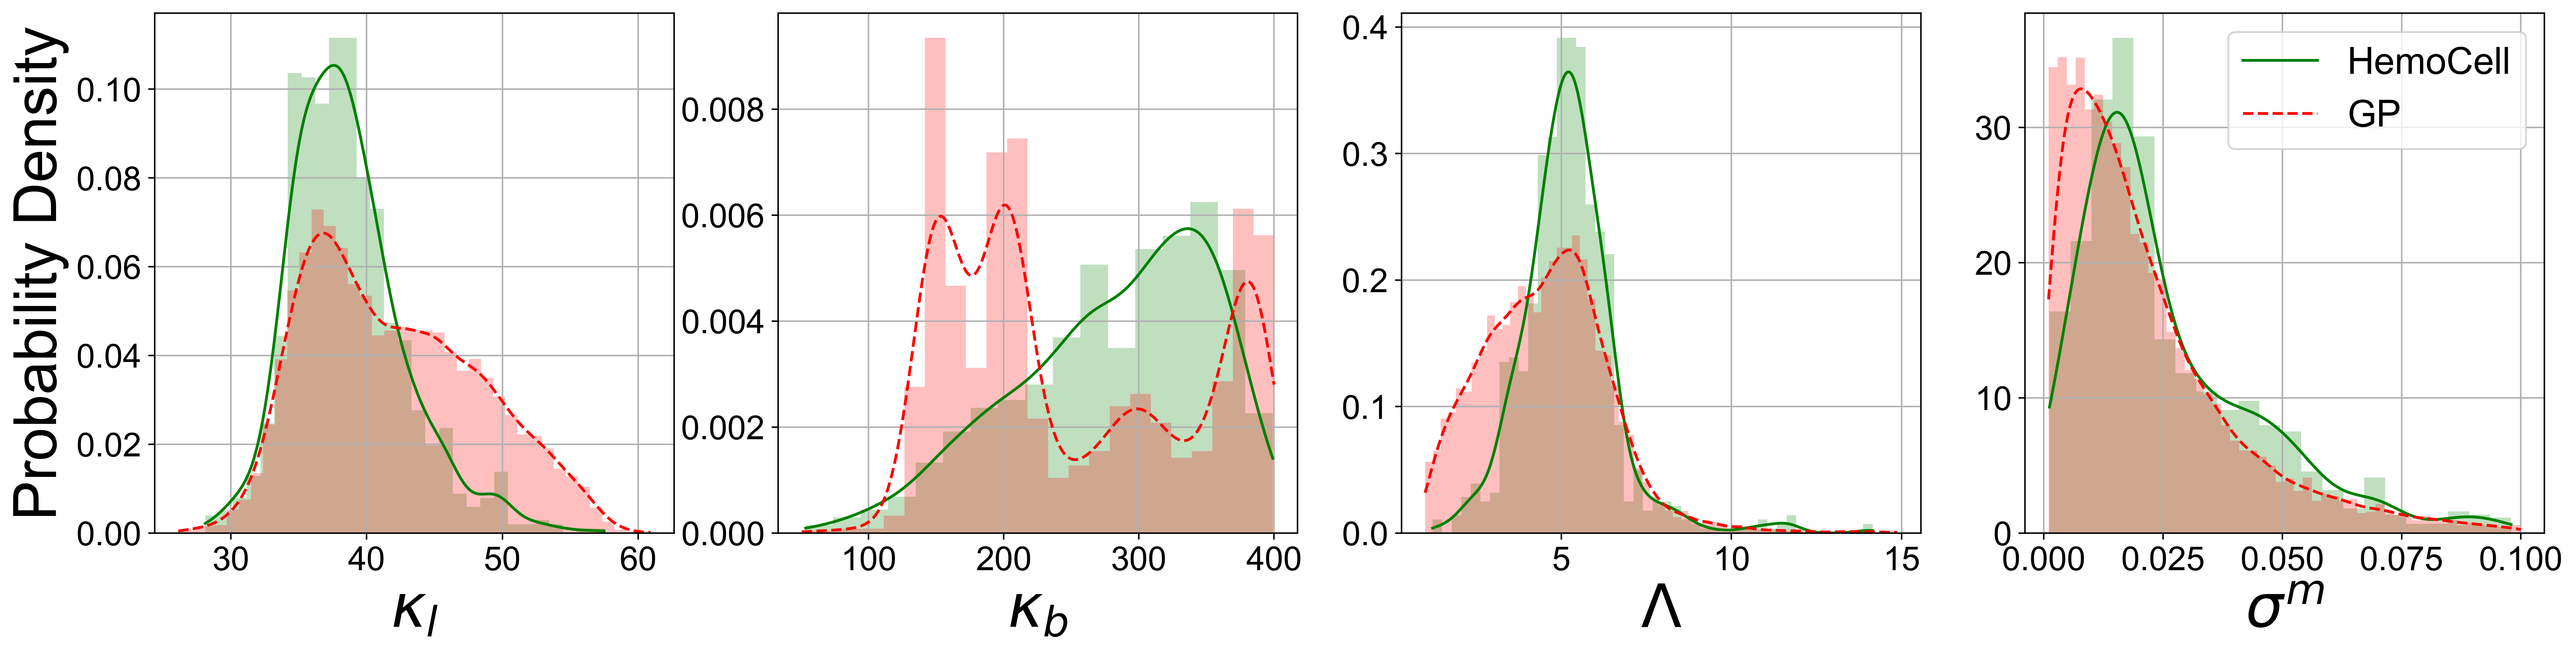

In [142]:
# bw options: normal_reference, cv_ml, cv_ls

plt.figure(figsize=(23,6))
for n,param in enumerate(params + ["err"]):
    ax = plt.subplot(1,4,n+1)
    plt.grid(True)
    
    if n == 0:
        plt.ylabel("Probability Density",fontsize=32)
    
    plt.xlabel(names[param],fontsize=32)
    
    HC_vals = HC_df[param].values
    HC_kde = sm.nonparametric.KDEMultivariate(data=HC_vals,var_type="c",bw="normal_reference")
    HC_x_vals = np.linspace(np.min(HC_vals),np.max(HC_vals),1000)
    HC_y_vals = HC_kde.pdf(HC_x_vals)
    
    print("HC KDE maximum of",param+":",HC_x_vals[np.argmax(HC_y_vals)])
    
    GP_vals = GP_df[param].values
    GP_kde = sm.nonparametric.KDEMultivariate(data=GP_vals,var_type="c",bw="normal_reference")
    GP_x_vals = np.linspace(np.min(GP_vals),np.max(GP_vals),1000)
    GP_y_vals = GP_kde.pdf(GP_x_vals)
    
    print("GP KDE maximum of",param+":",GP_x_vals[np.argmax(GP_y_vals)])
    
    plt.hist(HC_df[param].values,color=HC_violin_color,bins="auto",
             density=True,alpha=0.25)
    
    plt.plot(HC_x_vals,HC_y_vals,'-',color=HC_violin_color,label="HemoCell")
    
    plt.hist(GP_df[param].values,color=GP_violin_color,bins="auto",
             density=True,alpha=0.25)
    
    plt.plot(GP_x_vals,GP_y_vals,'--',color=GP_violin_color,label="GP")
    
    x0,x1 = plt.gca().get_xlim()
    y0,y1 = plt.gca().get_ylim()

    plt.gca().set_aspect((x1-x0)/(y1-y0))
    
ax.legend(fontsize=20)
plt.savefig("%s/TMCMC_%s_1D_marginals.%s" % (figpath,cellHealth,figformat),dpi=figdpi,bbox_inches="tight")

## 2D Samples scatterplot (Left: HemoCell, Right: GP model)

In [ ]:
pad = 0.06

ny,nx = 3,2
fig, axs = plt.subplots(ny,nx,figsize=(13,20))
orientation = "horizontal"

flat = axs.flatten()

flat[0].set_title("HemoCell",fontsize=32)
flat[1].set_title("GP",fontsize=32)

count = 2
s = 5

plots = []
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            HC_vals = HC_df[[params[n],params[m]]].values
            GP_vals = GP_df[[params[n],params[m]]].values
            
            xmin = min(np.min(HC_vals[:,0]),np.min(GP_vals[:,0]))
            xmax = max(np.max(HC_vals[:,0]),np.max(GP_vals[:,0]))
            
            ymin = min(np.min(HC_vals[:,1]),np.min(GP_vals[:,1]))
            ymax = max(np.max(HC_vals[:,1]),np.max(GP_vals[:,1]))
            
            HC_logs = np.log(HC_df["likelihood"].values)
            GP_logs = np.log(GP_df["likelihood"].values)

            vmin = min(np.min(HC_logs),np.min(GP_logs))
            vmax = max(np.max(HC_logs),np.max(GP_logs))
            
            flat[count-2].grid(True)
            flat[count-2].set_xlabel(names[params[n]],fontsize=32)
            flat[count-2].set_ylabel(names[params[m]],fontsize=32)
                
            flat[count-2].set_xlim(xmin,xmax)
            flat[count-2].set_ylim(ymin,ymax)
                
            order = np.argsort(HC_df["likelihood"])
            plots.append(flat[count-2].scatter(HC_df[params[n]].values[order],
                                               HC_df[params[m]].values[order],
                                               s=s,c=np.log(HC_df["likelihood"].values[order]),
                                               vmin=vmin,vmax=vmax,cmap="plasma",alpha=0.75))
            
            x0,x1 = flat[count-2].get_xlim()
            y0,y1 = flat[count-2].get_ylim()
            
            flat[count-2].set_aspect((x1-x0)/(y1-y0))
            
                
            flat[count-1].grid(True)
            flat[count-1].set_xlabel(names[params[n]],fontsize=32)
            flat[count-1].set_ylabel(names[params[m]],fontsize=32)
            
            flat[count-1].set_xlim(xmin,xmax)
            flat[count-1].set_ylim(ymin,ymax)
                
            order = np.argsort(GP_df["likelihood"])
            plots.append(flat[count-1].scatter(GP_df[params[n]].values[order],
                                               GP_df[params[m]].values[order],
                                               s=s,c=np.log(GP_df["likelihood"].values[order]),
                                               vmin=vmin,vmax=vmax,cmap="plasma",alpha=0.75))
            
            x0,x1 = flat[count-1].get_xlim()
            y0,y1 = flat[count-1].get_ylim()
            
            flat[count-1].set_aspect((x1-x0)/(y1-y0))
            
            count += 2
            
fig.colorbar(plots[-2],ax=axs[:,0],fraction=0.015,
             pad=pad,orientation=orientation).set_label(label="log likelihood",size=24)

fig.colorbar(plots[-1],ax=axs[:,1],fraction=0.015,
             pad=pad,orientation=orientation).set_label(label="log likelihood",size=24)

plt.savefig("%s/TMCMC_%s_2D_samples.%s" % (figpath,cellHealth,figformat),dpi=figdpi,bbox_inches="tight")

## 2D Kernel Density Estimations (Left: HemoCell, Right: GP)

In [40]:
plt.figure(figsize=(16.5,20))
fontsize = 38

count = 1

plots = []
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            HC_vals = HC_df[[params[n],params[m]]].values
            GP_vals = GP_df[[params[n],params[m]]].values
            
            xmin = min(np.min(HC_vals[:,0]),np.min(GP_vals[:,0]))
            xmax = max(np.max(HC_vals[:,0]),np.max(GP_vals[:,0]))
            
            ymin = min(np.min(HC_vals[:,1]),np.min(GP_vals[:,1]))
            ymax = max(np.max(HC_vals[:,1]),np.max(GP_vals[:,1]))
            
            HC_kde = sm.nonparametric.KDEMultivariate(data=HC_vals,var_type="cc",bw="normal_reference")
            GP_kde = sm.nonparametric.KDEMultivariate(data=GP_vals,var_type="cc",bw="normal_reference")
            
            x = np.linspace(xmin,xmax,100)
            y = np.linspace(ymin,ymax,100)
            xx,yy = np.meshgrid(x,y)
            
            grid_flat = np.column_stack([xx.flatten(),yy.flatten()])
            
            HC_grid_vals = HC_kde.pdf(grid_flat).reshape(xx.shape)
            GP_grid_vals = GP_kde.pdf(grid_flat).reshape(xx.shape)
            
            vmin = min(np.min(HC_grid_vals),np.min(GP_grid_vals))
            vmax = max(np.max(HC_grid_vals),np.max(GP_grid_vals))
            
            levels = np.linspace(vmin,vmax,8)
            
            ax = plt.subplot(3,2,count)
            
            if count == 1:
                plt.title("HemoCell",fontsize=fontsize)
            
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=fontsize)
            plt.ylabel(names[params[m]],fontsize=fontsize)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            
            cont = plt.contourf(xx,yy,HC_grid_vals,vmin=vmin,vmax=vmax,levels=levels,cmap=HC_cmap)
            cbar = plt.colorbar(cont)
                                        
            cbar.formatter.set_powerlimits((-4,-3))
            cbar.update_ticks()
            
            x0,x1 = plt.gca().get_xlim()
            y0,y1 = plt.gca().get_ylim()
            
            plt.gca().set_aspect((x1-x0)/(y1-y0))
            
            count += 1
            
            plt.subplot(3,2,count)
            
            if count == 2:
                plt.title("GP",fontsize=fontsize)
            
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=fontsize)
            plt.ylabel(names[params[m]],fontsize=fontsize)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            
            cont = plt.contourf(xx,yy,GP_grid_vals,vmin=vmin,vmax=vmax,levels=levels,cmap=GP_cmap)
            cbar = plt.colorbar(cont)
                        
            cbar.formatter.set_powerlimits((-4,-3))
            cbar.update_ticks()
            
            cbar.set_label("Probability Density",size=fontsize)
            
            x0,x1 = plt.gca().get_xlim()
            y0,y1 = plt.gca().get_ylim()
            
            plt.gca().set_aspect((x1-x0)/(y1-y0))
                
            count += 1


plt.savefig("%s/TMCMC_%s_2D_kdes.%s" % (figpath,cellHealth,figformat),dpi=figdpi,bbox_inches="tight")

## MAP and statistics

In [19]:
print("Posterior HemoCell parameter statistics:\n")
for param in params:
    param_vals = HC_df[param].values
    print("%s mean:" % param,param_vals.mean())
    print("%s std:" % param,param_vals.std(ddof=1))

print("\n========================================\n")
    
print("Posterior GP parameter statistics:\n")
for param in params:
    param_vals = GP_df[param].values
    print("%s mean:" % param,param_vals.mean())
    print("%s std:" % param,param_vals.std(ddof=1))

Posterior HemoCell parameter statistics:

kLink mean: 38.5909470813588
kLink std: 4.182924030796771
kBend mean: 282.16187783294066
kBend std: 71.94171735956799
viscosityRatio mean: 5.230710108695399
viscosityRatio std: 1.4085192906899286


Posterior GP parameter statistics:

kLink mean: 37.386275057799395
kLink std: 5.48392431843591
kBend mean: 284.3785814997157
kBend std: 82.97993242537727
viscosityRatio mean: 5.806302410574934
viscosityRatio std: 1.7691636899676324


In [20]:
HC_mpe = np.argmax(HC_df["likelihood"].values * HC_df["prior"].values)

print("Best sample HemoCell:")
print(HC_df.loc[HC_mpe])
print("Computation errors:")
print(HC_c_err[HC_mpe])

print("\n==============================\n")

GP_mpe = np.argmax(GP_df["likelihood"].values * GP_df["prior"].values)

print("Best sample GP:")
print(GP_df.loc[GP_mpe])
print("Computation errors:")
print(GP_c_err[GP_mpe])

Best sample HemoCell:
kLink             3.876776e+01
kBend             2.931739e+02
viscosityRatio    4.924145e+00
err               1.438219e-02
likelihood        5.450739e+09
prior             7.108381e-06
Name: 369, dtype: float64
Computation errors:
[0.00926994 0.00586313 0.00580052 0.00605132 0.00472985 0.00627777]


Best sample GP:
kLink             3.291577e+01
kBend             3.928408e+02
viscosityRatio    6.240974e+00
err               9.957875e-03
likelihood        6.232852e+09
prior             7.108381e-06
Name: 2306, dtype: float64
Computation errors:
[0.00373908 0.00356602 0.00355041 0.00346849 0.00350305 0.0035945 ]


## Uncertainty Propagation

In [145]:
# Get healthy sample data
healthy_samples = pd.read_csv("%s/TMCMC_hemocell_healthy_%s_samples_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.csv" % 
                              (outputpath,healthyErrType,HC_lmax,HC_nburn,HC_nsamples),sep=";")

healthy_qoi = np.load("%s/TMCMC_hemocell_healthy_%s_qoi_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                      (outputpath,healthyErrType,HC_lmax,HC_nburn,HC_nsamples))

healthy_c_err = np.load("%s/TMCMC_hemocell_healthy_%s_c_err_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                        (outputpath,healthyErrType,HC_lmax,HC_nburn,HC_nsamples))

# Get treated sample data
treated_samples = pd.read_csv("%s/TMCMC_hemocell_treated_%s_samples_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.csv" % 
                              (outputpath,treatedErrType,HC_lmax,HC_nburn,HC_nsamples),sep=";")

treated_qoi = np.load("%s/TMCMC_hemocell_treated_%s_qoi_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                      (outputpath,treatedErrType,HC_lmax,HC_nburn,HC_nsamples))

treated_c_err = np.load("%s/TMCMC_hemocell_treated_%s_c_err_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                        (outputpath,treatedErrType,HC_lmax,HC_nburn,HC_nsamples))

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")
healthy_data = data.loc[data["Treatment"] == 0]
treated_data = data.loc[data["Treatment"] == 0.5]

healthy_stress,healthy_el,healthy_el_err = healthy_data.values[2:8,[1,2,3]].T 
treated_stress,treated_el,treated_el_err = treated_data.values[4:10,[1,2,3]].T

# Get full dataset used
full_healthy_stress,full_healthy_el,full_healthy_el_err = data.values[2:10,[1,2,3]].T 
full_treated_stress,full_treated_el,full_treated_el_err = data.values[2:10,[1,2,3]].T

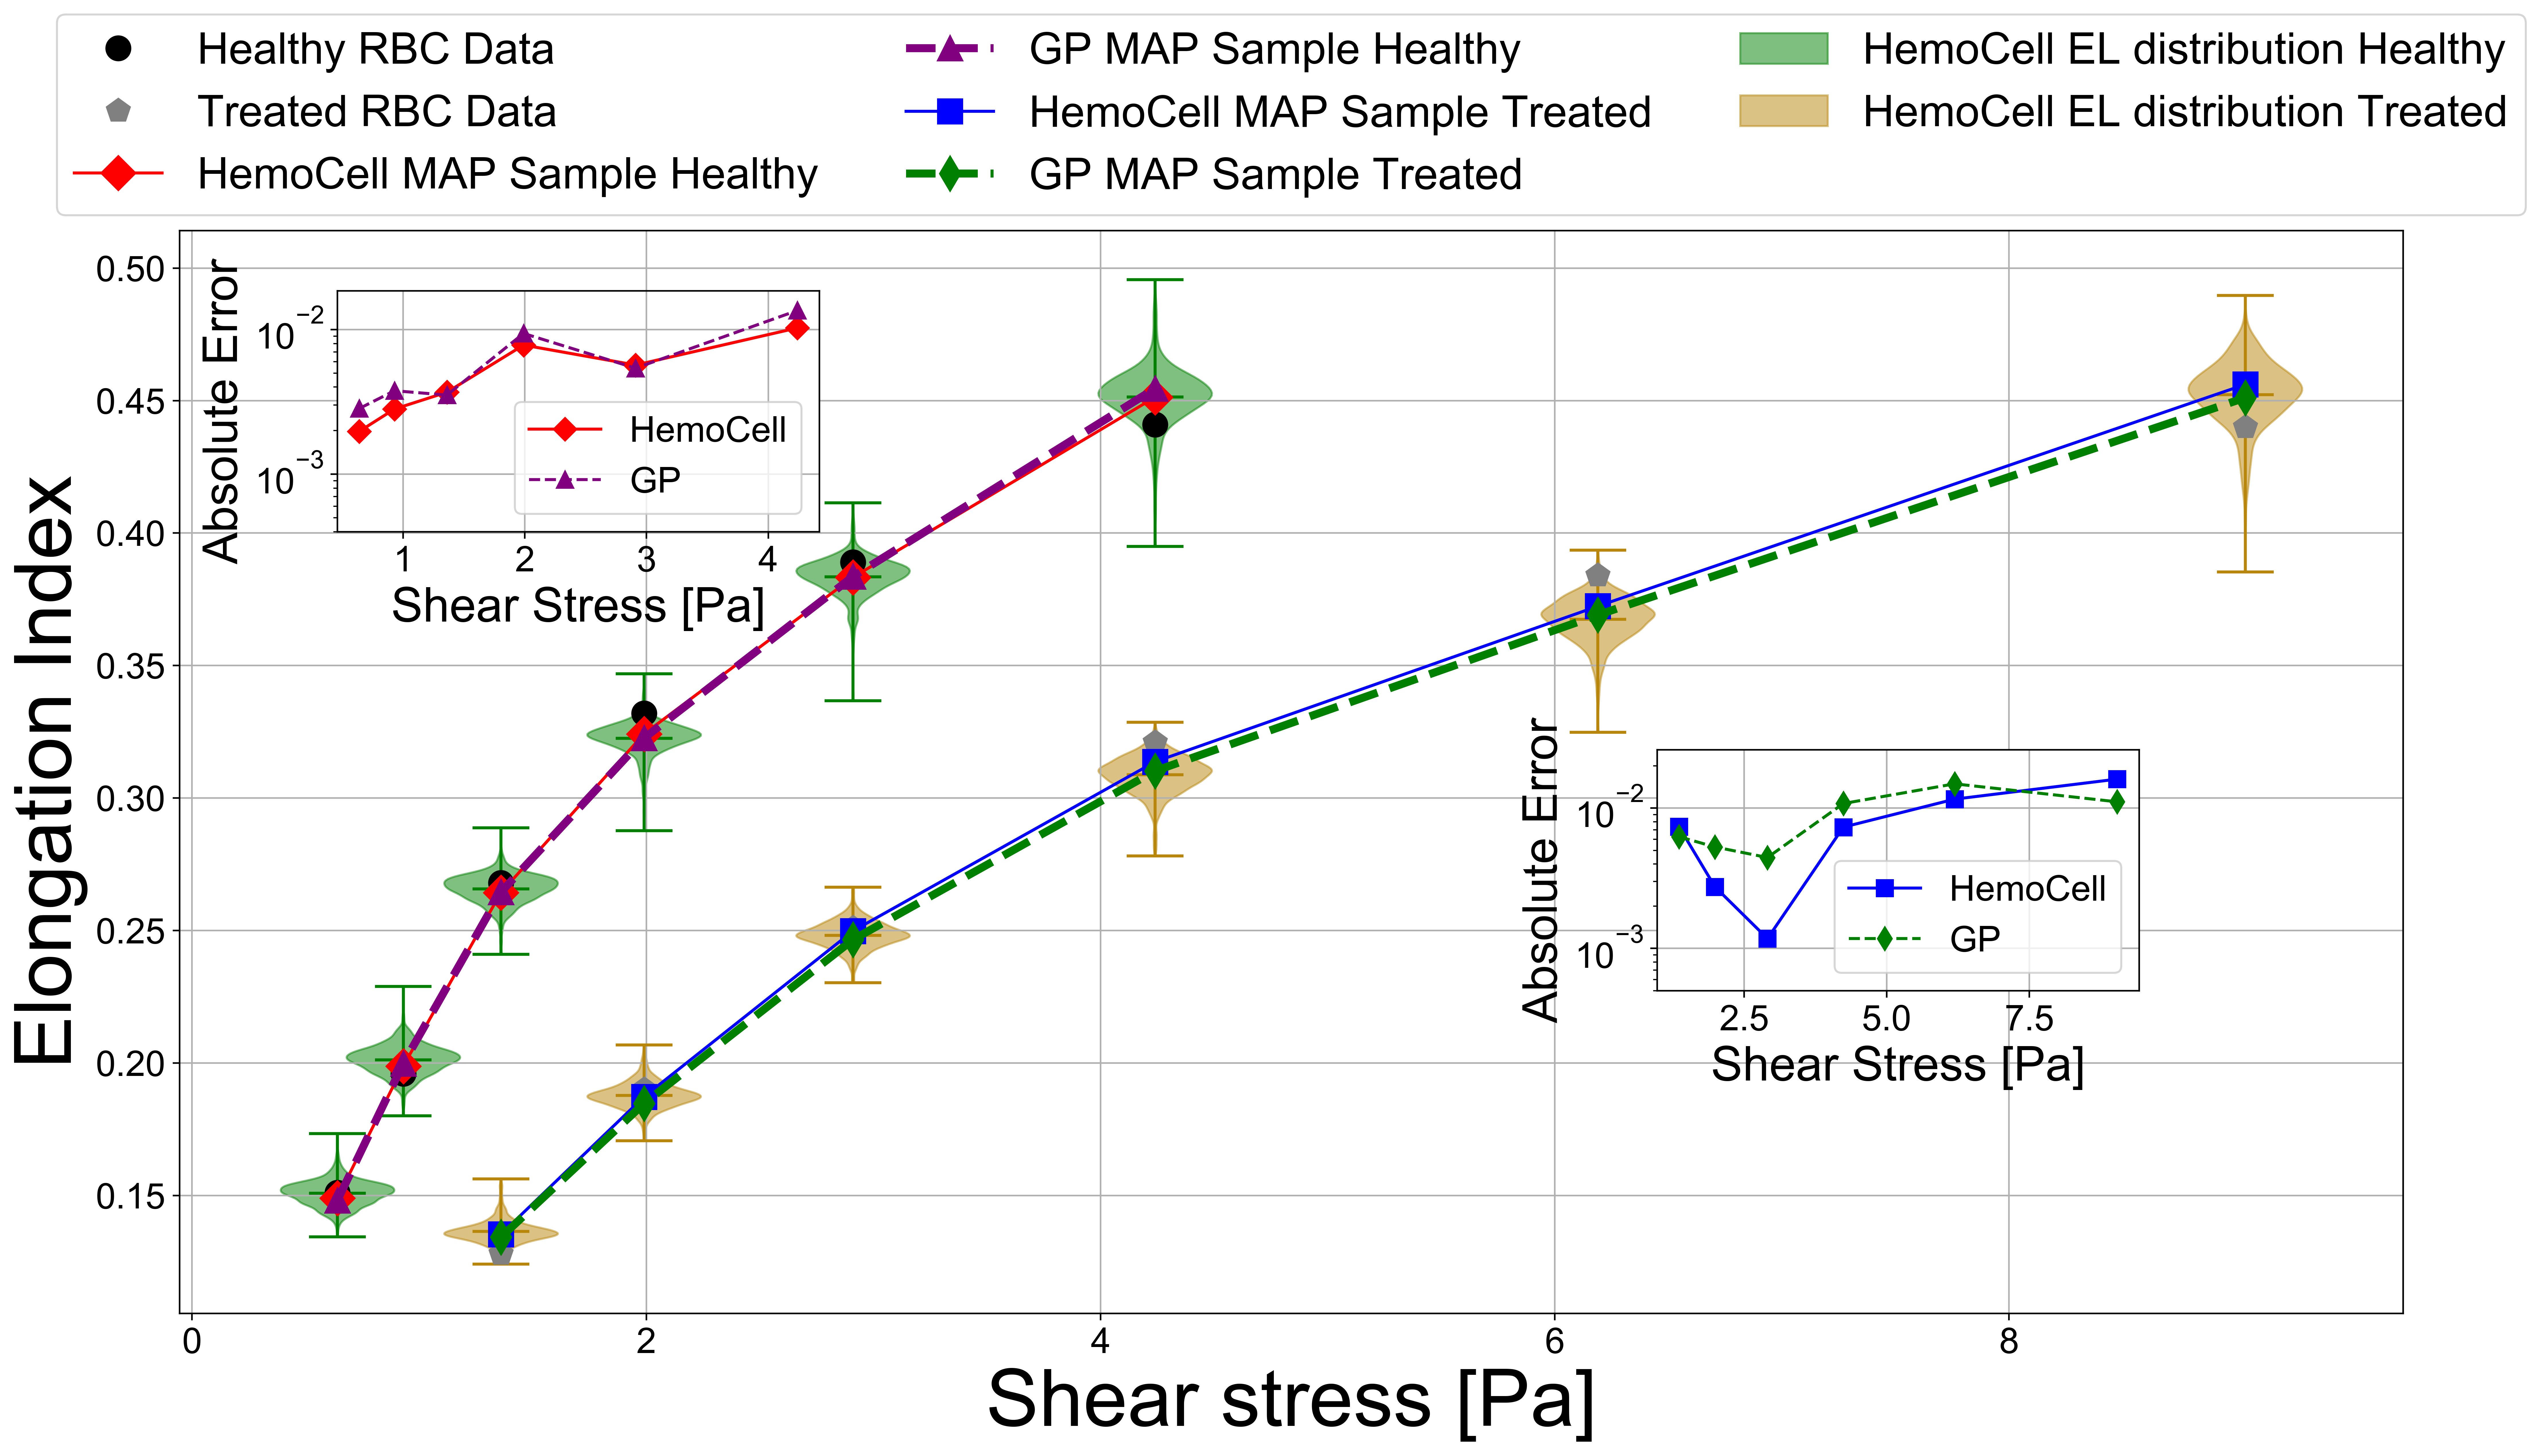

In [146]:
ms = 12

fig = plt.figure(figsize=(20,10))

plt.xlabel("Shear stress [Pa]",fontsize=40)
plt.ylabel("Elongation Index",fontsize=40)

plt.grid(True)

# Data
plt.plot(healthy_stress,healthy_el,"o",markersize=ms,color="black",label="Healthy RBC Data")

plt.plot(treated_stress,treated_el,"p",markersize=ms,color="grey",label="Treated RBC Data")

# MAP samples

## Healthy
mpe = np.argmax(healthy_samples["likelihood"].values * healthy_samples["prior"].values)
mpe_label = "HemoCell MAP Sample Healthy"

plt.plot(healthy_stress,healthy_qoi[mpe],"D-",markersize=ms,color="red",label=mpe_label)

true_mpe_qoi = np.load("%s/TMCMC_%s_healthy_%s_qoi_visc_2_8_lmax_%s_nburn_%i_nsamples_%i_mpe_sample.npy" % 
                       (outputpath,gpModelType,healthyErrType,GP_lmax,GP_nburn,GP_nsamples)).flatten()

true_mpe_c_err = np.load("%s/TMCMC_%s_healthy_%s_c_err_visc_2_8_lmax_%s_nburn_%i_nsamples_%i_mpe_sample.npy" % 
                         (outputpath,gpModelType,healthyErrType,GP_lmax,GP_nburn,GP_nsamples)).flatten()

plt.plot(healthy_stress,true_mpe_qoi,"^--",markersize=ms,color="purple",linewidth=4,label="GP MAP Sample Healthy")

HC_err_healthy = abs(healthy_qoi[mpe] - healthy_el)
GP_err_healthy = abs(true_mpe_qoi - healthy_el)

## Treated

mpe = np.argmax(treated_samples["likelihood"].values * treated_samples["prior"].values)
mpe_label = "HemoCell MAP Sample Treated"

plt.plot(treated_stress,treated_qoi[mpe],"s-",markersize=ms,color="blue",label=mpe_label)

true_mpe_qoi = np.load("%s/TMCMC_%s_treated_%s_qoi_visc_4_10_lmax_%s_nburn_%i_nsamples_%i_mpe_sample.npy" % 
                       (outputpath,gpModelType,treatedErrType,GP_lmax,GP_nburn,GP_nsamples)).flatten()

true_mpe_c_err = np.load("%s/TMCMC_%s_treated_%s_c_err_visc_4_10_lmax_%s_nburn_%i_nsamples_%i_mpe_sample.npy" % 
                         (outputpath,gpModelType,treatedErrType,GP_lmax,GP_nburn,GP_nsamples)).flatten()

plt.plot(treated_stress,true_mpe_qoi,"d--",markersize=ms,color="green",linewidth=4,label="GP MAP Sample Treated")

HC_err_treated = abs(treated_qoi[mpe] - treated_el)
GP_err_treated = abs(true_mpe_qoi - treated_el)

# Healthy violin
violin_parts = plt.violinplot(healthy_qoi,healthy_stress,showmeans=True)

# Set transparency for violinplot distribution
alpha_val = 0.5

for partname in ['cbars','cmins','cmaxes','cmeans']:
    vp = violin_parts[partname]
    vp.set_edgecolor("green")

for vp in violin_parts["bodies"]:
    vp.set_facecolor("green")
    vp.set_edgecolor("green")
    vp.set_alpha(alpha_val)

# Treated violin
violin_parts = plt.violinplot(treated_qoi,treated_stress,showmeans=True)

pretentious_color = "darkgoldenrod"
for partname in ['cbars','cmins','cmaxes','cmeans']:
    vp = violin_parts[partname]
    vp.set_edgecolor(pretentious_color)

for vp in violin_parts["bodies"]:
    vp.set_facecolor(pretentious_color)
    vp.set_edgecolor(pretentious_color)
    vp.set_alpha(alpha_val)

    
handles,labels = plt.gca().get_legend_handles_labels()

healthy_patch = mpatches.Patch(color = "green", alpha=alpha_val, 
                               label = "HemoCell EL distribution Healthy")
treated_patch = mpatches.Patch(color = pretentious_color, alpha=alpha_val, 
                               label = "HemoCell EL distribution Treated")

handles = handles + [healthy_patch,treated_patch]
plt.legend(handles=handles,loc='upper center',bbox_to_anchor=(0.5,1.22),ncol=3,fontsize=22)

# Inset Healthy
ax_inset = fig.add_axes([0.18,0.67,0.168,0.168])
ax_inset.set_xlabel("Shear Stress [Pa]",fontsize=24)
ax_inset.set_ylabel("Absolute Error",fontsize=24)
ax_inset.set_yscale("log")
plt.ylim(4e-4,max(np.max(HC_err_healthy), np.max(GP_err_healthy))+5e-3)
ax_inset.grid(True)
ax_inset.plot(healthy_stress,HC_err_healthy,"D-",markersize=8,color="red",label="HemoCell")
ax_inset.plot(healthy_stress,GP_err_healthy,"^--",markersize=8,color="purple",label="GP")
ax_inset.legend(loc="lower right",fontsize=18)

# Inset Treated
ax_inset = fig.add_axes([0.64,0.35,0.168,0.168])
ax_inset.set_xlabel("Shear Stress [Pa]",fontsize=24)
ax_inset.set_ylabel("Absolute Error",fontsize=24)
ax_inset.set_yscale("log")
plt.ylim(5e-4,max(np.max(HC_err_treated), np.max(GP_err_treated))+1e-2)
ax_inset.grid(True)
ax_inset.plot(treated_stress,HC_err_treated,"s-",markersize=8,color="blue",label="HemoCell")
ax_inset.plot(treated_stress,GP_err_treated,"d--",markersize=8,color="green",label="GP")
ax_inset.legend(loc="lower right",fontsize=18)

plt.savefig("%s/TMCMC_propagation.%s" % (figpath,figformat),dpi=figdpi,bbox_inches="tight")

# Compare MAP samples between GP and HemoCell

In [21]:
def normal_likelihood(output, data, data_err, comp_err, model_err):
    """
    The standard likelihood function used for the TMCMC algorithm
    """

    covariance_matrix = np.diag(data_err**2 + 
                                (comp_err * data)**2 + 
                                (model_err * data)**2)
    
    return multivariate_normal.pdf(data,mean=output,cov=covariance_matrix)

In [22]:
# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")

healthy_data = data.loc[data["Treatment"] == 0]
treated_data = data.loc[data["Treatment"] == 0.5]

healthy_el,healthy_el_err = healthy_data.values[2:8,[2,3]].T
treated_el,treated_el_err = treated_data.values[4:10,[2,3]].T

In [23]:
# Get healthy HemoCell sample data
HC_healthy_samples = pd.read_csv("%s/TMCMC_hemocell_healthy_%s_samples_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.csv" % 
                                 (outputpath,healthyErrType,HC_lmax,HC_nburn,HC_nsamples),sep=";")

HC_healthy_qoi = np.load("%s/TMCMC_hemocell_healthy_%s_qoi_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                         (outputpath,healthyErrType,HC_lmax,HC_nburn,HC_nsamples))

HC_healthy_c_err = np.load("%s/TMCMC_hemocell_healthy_%s_c_err_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                           (outputpath,healthyErrType,HC_lmax,HC_nburn,HC_nsamples))

# Get treated HemoCell sample data
HC_treated_samples = pd.read_csv("%s/TMCMC_hemocell_treated_%s_samples_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.csv" % 
                                 (outputpath,treatedErrType,HC_lmax,HC_nburn,HC_nsamples),sep=";")

HC_treated_qoi = np.load("%s/TMCMC_hemocell_treated_%s_qoi_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                         (outputpath,treatedErrType,HC_lmax,HC_nburn,HC_nsamples))

HC_treated_c_err = np.load("%s/TMCMC_hemocell_treated_%s_c_err_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                           (outputpath,treatedErrType,HC_lmax,HC_nburn,HC_nsamples))

# Get healthy GP sample data with EL error
GP_healthy_samples = pd.read_csv("%s/TMCMC_%s_healthy_%s_samples_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.csv" % 
                                 (outputpath,gpModelType,healthyErrType,GP_lmax,GP_nburn,GP_nsamples),sep=";")

GP_healthy_qoi = np.load("%s/TMCMC_%s_healthy_%s_qoi_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                         (outputpath,gpModelType,healthyErrType,GP_lmax,GP_nburn,GP_nsamples))

GP_healthy_c_err = np.load("%s/TMCMC_%s_healthy_%s_c_err_visc_2_8_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                           (outputpath,gpModelType,healthyErrType,GP_lmax,GP_nburn,GP_nsamples))

GP_healthy_mpe_qoi = np.load("%s/TMCMC_%s_healthy_%s_qoi_visc_2_8_lmax_%s_nburn_%i_nsamples_%i_mpe_sample.npy" % 
                             (outputpath,gpModelType,healthyErrType,GP_lmax,GP_nburn,GP_nsamples)).flatten()

GP_healthy_mpe_c_err = np.load("%s/TMCMC_%s_healthy_%s_c_err_visc_2_8_lmax_%s_nburn_%i_nsamples_%i_mpe_sample.npy" % 
                               (outputpath,gpModelType,healthyErrType,GP_lmax,GP_nburn,GP_nsamples)).flatten()

# Get treated GP sample data
GP_treated_samples = pd.read_csv("%s/TMCMC_%s_treated_%s_samples_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.csv" % 
                                 (outputpath,gpModelType,treatedErrType,GP_lmax,GP_nburn,GP_nsamples),sep=";")

GP_treated_qoi = np.load("%s/TMCMC_%s_treated_%s_qoi_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                         (outputpath,gpModelType,treatedErrType,GP_lmax,GP_nburn,GP_nsamples))

GP_treated_c_err = np.load("%s/TMCMC_%s_treated_%s_c_err_visc_4_10_lmax_%s_nburn_%i_nsamples_%i.npy" % 
                           (outputpath,gpModelType,treatedErrType,GP_lmax,GP_nburn,GP_nsamples))

GP_treated_mpe_qoi = np.load("%s/TMCMC_%s_treated_%s_qoi_visc_4_10_lmax_%s_nburn_%i_nsamples_%i_mpe_sample.npy" % 
                         (outputpath,gpModelType,treatedErrType,GP_lmax,GP_nburn,GP_nsamples)).flatten()

GP_treated_mpe_c_err = np.load("%s/TMCMC_%s_treated_%s_c_err_visc_4_10_lmax_%s_nburn_%i_nsamples_%i_mpe_sample.npy" % 
                           (outputpath,gpModelType,treatedErrType,GP_lmax,GP_nburn,GP_nsamples)).flatten()

In [24]:
# Get MAP sample indices
HC_healthy_mpe = np.argmax(HC_healthy_samples["likelihood"].values * HC_healthy_samples["prior"].values)
HC_treated_mpe = np.argmax(HC_treated_samples["likelihood"].values * HC_treated_samples["prior"].values)
GP_healthy_mpe = np.argmax(GP_healthy_samples["likelihood"].values * GP_healthy_samples["prior"].values)
GP_treated_mpe = np.argmax(GP_treated_samples["likelihood"].values * GP_treated_samples["prior"].values)

HC_healthy_likelihood = normal_likelihood(HC_healthy_qoi[HC_healthy_mpe], healthy_el,
                                          healthy_el_err, HC_healthy_c_err[HC_healthy_mpe],
                                          HC_healthy_samples["err"].values[HC_healthy_mpe])

HC_treated_likelihood = normal_likelihood(HC_treated_qoi[HC_treated_mpe], treated_el,
                                          treated_el_err, HC_treated_c_err[HC_treated_mpe],
                                          HC_treated_samples["err"].values[HC_treated_mpe])

GP_healthy_likelihood = normal_likelihood(GP_healthy_mpe_qoi, healthy_el,
                                          healthy_el_err, GP_healthy_mpe_c_err,
                                          GP_healthy_samples["err"].values[GP_healthy_mpe])

GP_treated_likelihood = normal_likelihood(GP_treated_mpe_qoi, treated_el,
                                          treated_el_err, GP_treated_mpe_c_err,
                                          GP_treated_samples["err"].values[GP_treated_mpe])

In [25]:
print("HemoCell healthy likelihood:",HC_healthy_likelihood)
print("GP       healthy likelihood:",GP_healthy_likelihood)
print()
print("HemoCell treated likelihood:",HC_treated_likelihood)
print("GP       treated likelihood:",GP_treated_likelihood)

HemoCell healthy likelihood: 5450739443.550201
GP       healthy likelihood: 3081090484.420447

HemoCell treated likelihood: 747060274.5996182
GP       treated likelihood: 309313690.2096661


In [26]:
print("HemoCell healthy root mean squared error:",np.sqrt(np.mean((healthy_el - HC_healthy_qoi[HC_healthy_mpe])**2)))
print("GP       healthy root mean squared error:",np.sqrt(np.mean((healthy_el - GP_healthy_mpe_qoi)**2)))
print()
print("HemoCell treated root mean squared error:",np.sqrt(np.mean((treated_el - HC_treated_qoi[HC_treated_mpe])**2)))
print("GP       treated root mean squared error:",np.sqrt(np.mean((treated_el - GP_treated_mpe_qoi)**2)))

HemoCell healthy root mean squared error: 0.006109310001313328
GP       healthy root mean squared error: 0.0068112620614105245

HemoCell treated root mean squared error: 0.009221272563036838
GP       treated root mean squared error: 0.010509962733104996


# Convergence plots

In [23]:
imin = 0
imax = 10

stress,el = data.values[imin:imax,[1,2]].T
el_err = np.zeros(imax-imin)

healthy_qoi = np.load("%s/convergence_qoi_visc_%i_%i_15_80_5.npy" % (outputpath,imin,imax))
rigid_qoi = np.load("%s/convergence_qoi_visc_%i_%i_100_80_5.npy" % (outputpath,imin,imax))

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

threshold = 18

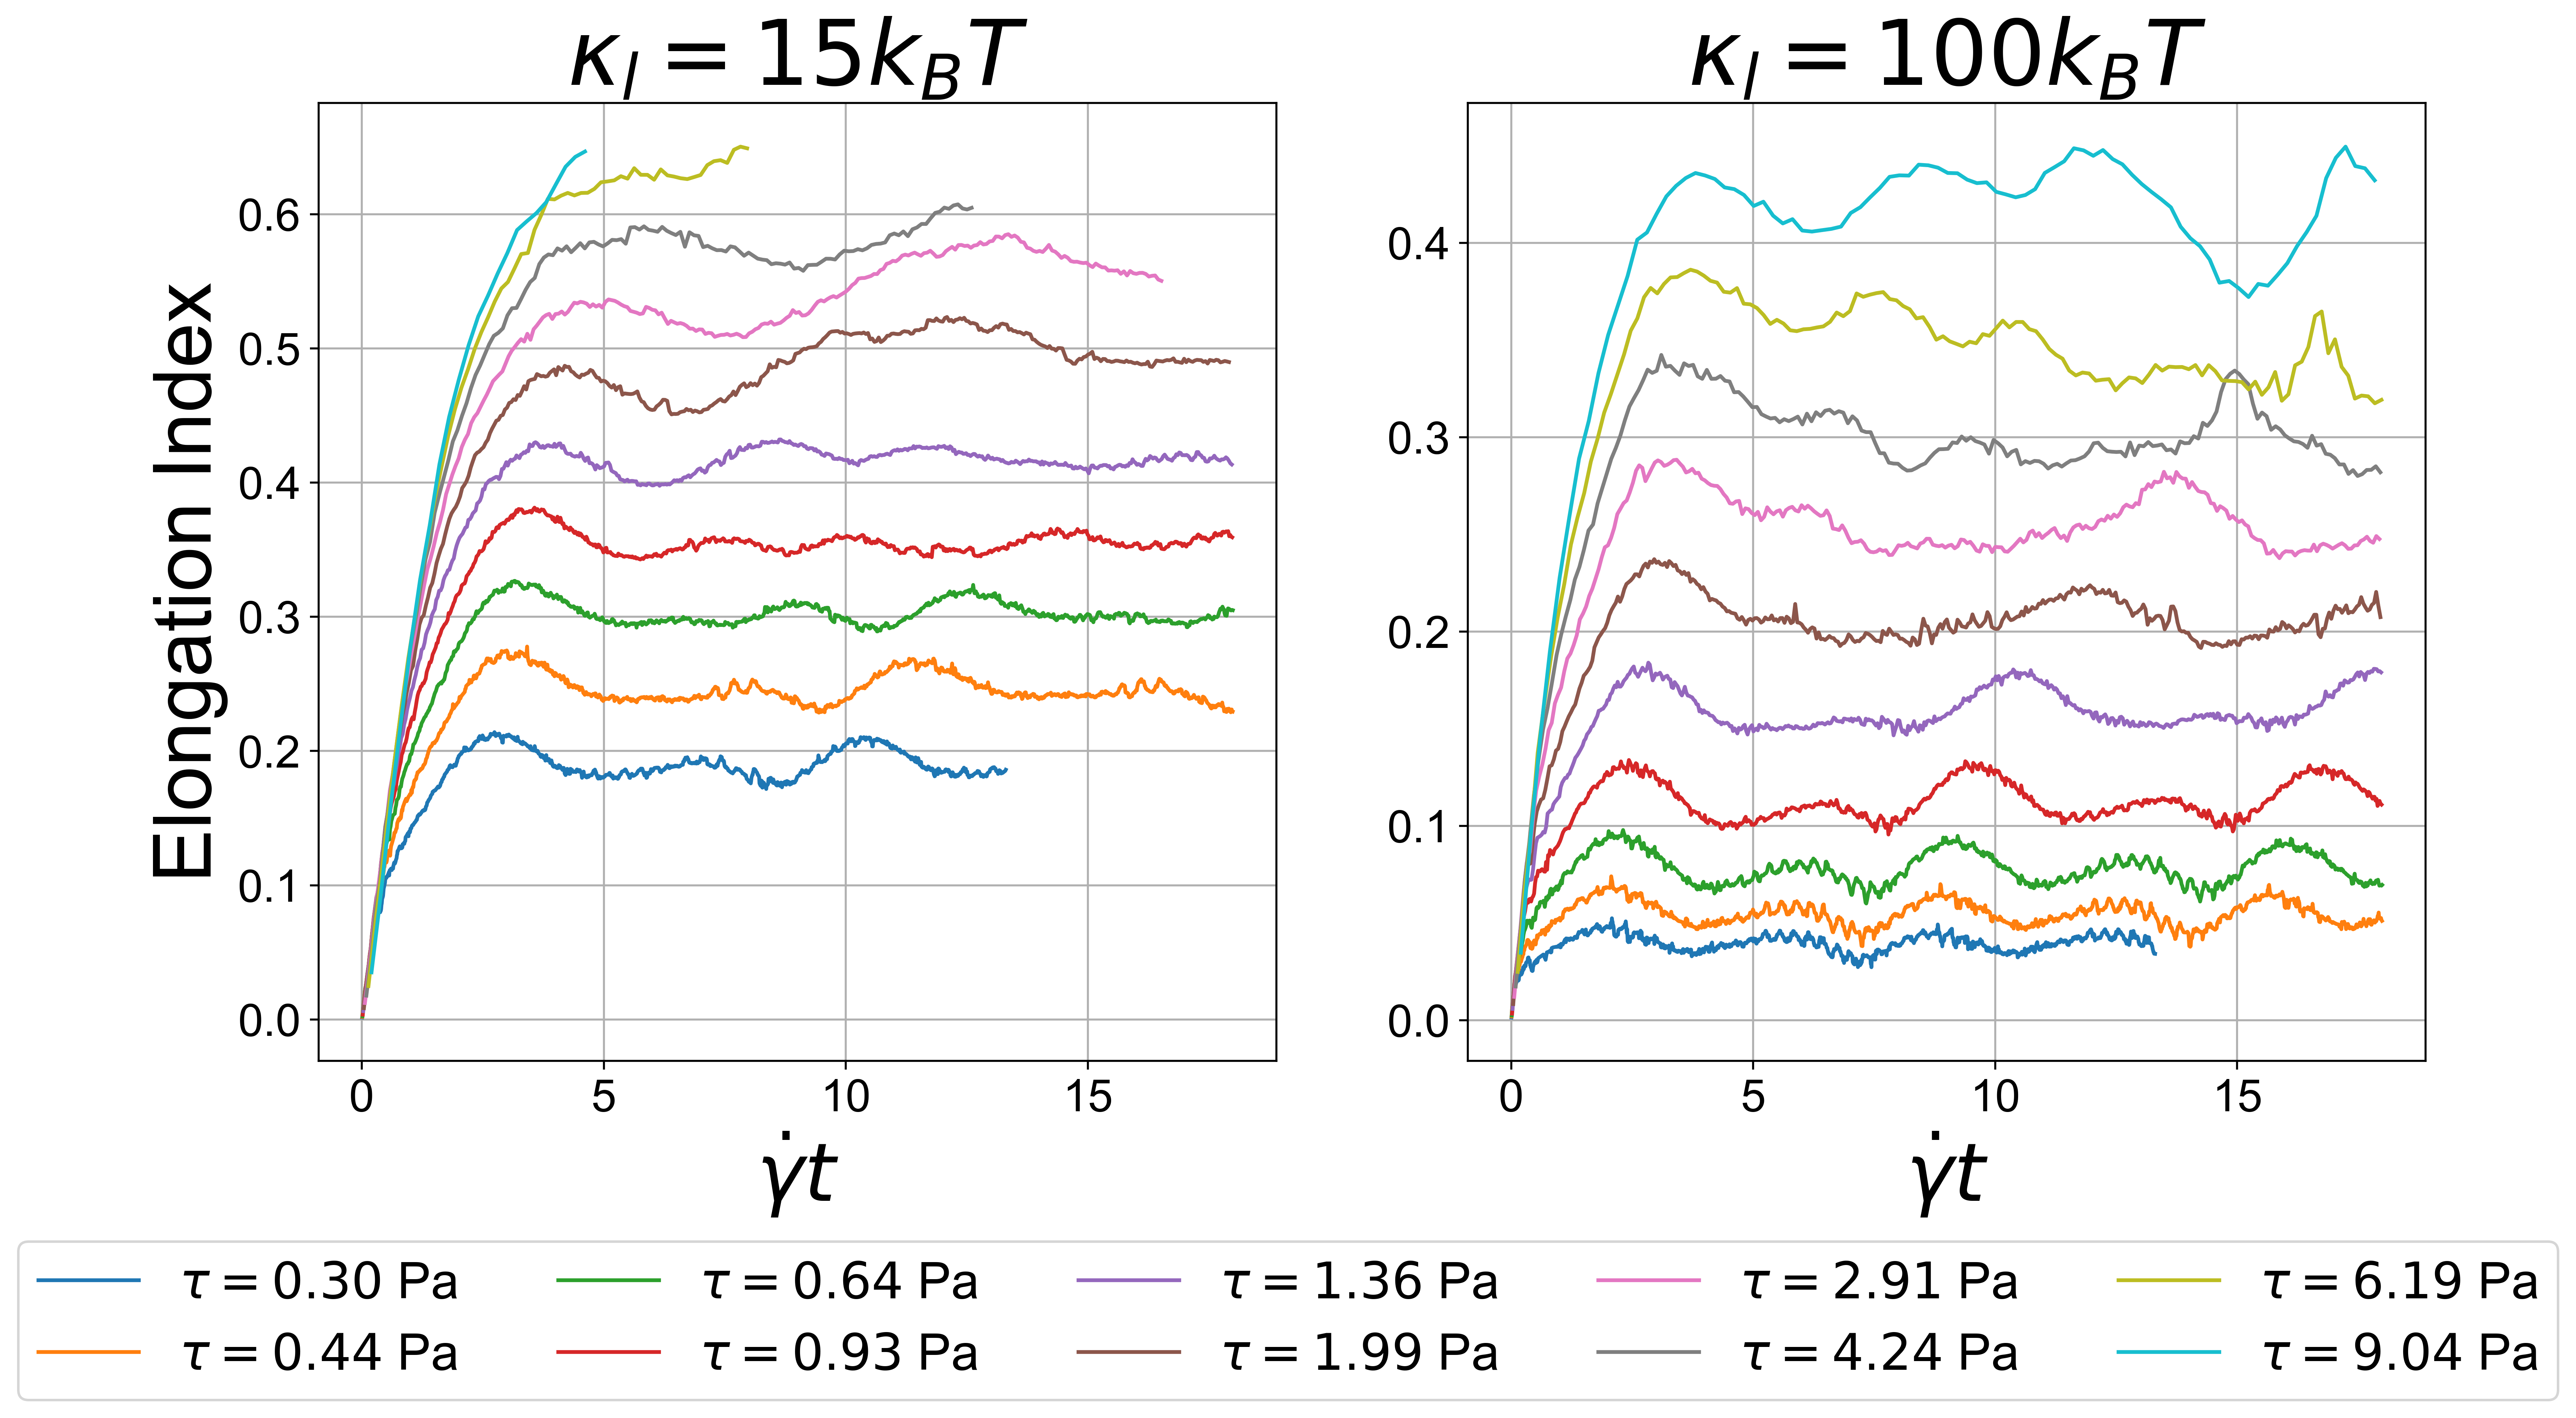

In [24]:
plt.figure(figsize=(15,9))
fig1 = plt.subplot(1,2,1)
plt.title(r"$\kappa_l = 15 k_B T$",fontsize=36)
plt.xlabel(r"$\dot{\gamma} t$",fontsize=32)
plt.ylabel(r"Elongation Index",fontsize=32)
plt.grid(True)

for n in range(10):
    steps = np.arange(500,1000001,500)[healthy_qoi[:,n] > 0]
    qoi = healthy_qoi[:,n][healthy_qoi[:,n] > 0]
    
    full_x_vals = steps * 0.5e-7 * shearrate[n]
    
    x_vals = full_x_vals[full_x_vals < threshold]
    y_vals = qoi[full_x_vals < threshold]
    
    plt.plot(x_vals,y_vals,label=r"$\tau = %.2f$ Pa" % (stress[n]))

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()
plt.gca().set_aspect((x1-x0)/(y1-y0))

fig2 = plt.subplot(1,2,2)
plt.title(r"$\kappa_l = 100 k_B T$",fontsize=36)
plt.xlabel(r"$\dot{\gamma} t$",fontsize=32)
plt.grid(True)

for n in range(10):
    steps = np.arange(500,1000001,500)[rigid_qoi[:,n] > 0]
    qoi = rigid_qoi[:,n][rigid_qoi[:,n] > 0]
    
    full_x_vals = steps * 0.5e-7 * shearrate[n]
    
    x_vals = full_x_vals[full_x_vals < threshold]
    y_vals = qoi[full_x_vals < threshold]
    
    plt.plot(x_vals,y_vals,label=r"$\tau = %.2f$ Pa" % (stress[n]))

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()
plt.gca().set_aspect((x1-x0)/(y1-y0))
    
fig1.legend(loc='lower left',bbox_to_anchor=(-0.34,-0.38),ncol=5,fontsize=20)
plt.savefig("%s/EL_convergence.%s" % (figpath,figformat),dpi=figdpi,bbox_inches="tight")

# SA visualizations

## Train prediction model for imputation

In [25]:
# Seed used for Master Thesis
np.random.seed(6345789)

# Load simulation data
mode="visc"

imin = 0
imax = 10

# Load simulation data
x_train = np.load("%s/train_hemocell_samples_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
y_train = np.load("%s/train_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
c_err = np.load("%s/train_hemocell_c_err_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

x_fail = x_train[y_train[:,0] < 0,:-3]

# Remove failed simulation outputs
x_train = x_train[y_train[:,0] >= 0,:-3]
c_err = c_err[y_train[:,0] >= 0]
y_train = y_train[y_train[:,0] >= 0]

In [ ]:
def singleModel(x_train,y_train,n_restarts=0,isotropic=True):
    
    if isotropic:
        length_scale = 1.0
    else:
        length_scale = np.ones(x_train.shape[1])
    
    kernel = RBF(length_scale) + WhiteKernel()
    return GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=n_restarts).fit(x_train,y_train)

def multipleModels(x_train,y_train,n_restarts=0,isotropic=True):
    params,shearrates = x_train[:,:-1],x_train[:,-1]
    
    if isotropic:
        length_scale = 1.0
    else:
        length_scale = np.ones(params.shape[1])
        
    kernels = {shearrate : RBF(length_scale) + WhiteKernel() for shearrate in np.unique(shearrates)}
    
    predictionModels = {}
    for shearrate in np.unique(shearrates):
        model = GaussianProcessRegressor(kernel=kernels[shearrate],
                                         n_restarts_optimizer=n_restarts).fit(params[shearrate == shearrates],
                                                                              y_train[shearrate == shearrates])
        
        predictionModels[shearrate] = model
        
    return predictionModels
    

# Train prediction model
if gpType == "multi":
    %time model = multipleModels(x_train,y_train,n_restarts=10,isotropic=isotropic)
elif gpType == "single":
    %time model = singleModel(x_train,y_train,n_restarts=1,isotropic=isotropic)

In [ ]:
def predictionModel(x,return_std=False):
    if type(model) is dict:
        return model[x[0,-1]].predict(x[:,:-1],return_std=return_std)
    else:
        return model.predict(x,return_std=return_std)

## HemoCell imputation and plots

In [26]:
imputation = "GP_model"

imin = 2
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,2,3]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

model_params = ["kLink","kBend","viscosityRatio"]

# Set the bounds on the parameters
bounds = [[10.0,300.0],
          [50.0,400.0],
          [1.0,15.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,1000,calc_second_order=False)
sobol_qoi = np.load("%s/sobol_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

In [ ]:
np.random.seed(6345789)

print("Crashed simulations:",np.sum(sobol_qoi < 0))

if imputation == "zero":
    sobol_qoi[sobol_qoi < 0] = 0
elif imputation == "GP_model":  
    sample_idx,var_idx = np.where(sobol_qoi < 0)
    for n in range(sample_idx.size):
        arr = np.array([*param_values[sample_idx[n]],shearrate[var_idx[n]]])[None,:]
        mean = predictionModel(arr)
    
        sobol_qoi[sample_idx[n],var_idx[n]] = mean

print("Imputation sanity check:",np.sum(sobol_qoi < 0))

In [ ]:
# Get the sobol indices
sobol_indices = [sobol.analyze(sobol_problem,sobol_qoi[:,m],
                               calc_second_order=False) for m in range(shearrate.size)]

S1 = np.array([sobol_indices[m]["S1"] for m in range(shearrate.size)]).T
ST = np.array([sobol_indices[m]["ST"] for m in range(shearrate.size)]).T

S1_conf = np.array([sobol_indices[m]["S1_conf"] for m in range(shearrate.size)]).T
ST_conf = np.array([sobol_indices[m]["ST_conf"] for m in range(shearrate.size)]).T

In [ ]:
plt.figure(figsize=(20,8))
for n in range(len(model_params)):
    plt.subplot(1,3,n+1)
    plt.title(names[model_params[n]],fontsize=40)
    plt.grid(True)
    plt.xlabel("Shear Stress [Pa]",fontsize=36)
    
    if n == 0:
        plt.ylabel("Sensitivity Index",fontsize=36)
    
    plt.errorbar(stress,S1[n],yerr=S1_conf[n],color="blue",fmt="s-",markersize=8,label="First order SI")
    plt.errorbar(stress,ST[n],yerr=ST_conf[n],color="orange",fmt="o-",markersize=8,label="Total SI")
    
    x0,x1 = plt.gca().get_xlim()
    y0,y1 = plt.gca().get_ylim()

    plt.gca().set_aspect((x1-x0)/(y1-y0))
    
    if n == 0:
        plt.legend(fontsize=24)

plt.savefig("%s/sobol_hemocell_visc_2_10.%s" % (figpath,figformat),dpi=figdpi,bbox_inches="tight")

## GP evaluation and plots

In [27]:
imin = 2
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress = data.values[imin:imax,1]

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

In [ ]:
n_samples = 10000

model_params = ["kLink","kBend","viscosityRatio"]

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Set the bounds on the parameters
bounds = [[10.0,300.0],
          [50.0,400.0],
          [1.0,15.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,n_samples,calc_second_order=False)

sobol_qoi = np.zeros((param_values.shape[0],shearrate.size))

with tqdm.tqdm(total=sobol_qoi.size) as pbar:
    for n,param_set in enumerate(param_values):
        for m,design_val in enumerate(shearrate):
            arr = np.array([*param_values[n],design_val])[None,:]
            mean = predictionModel(arr)

            sobol_qoi[n,m] = mean
            
            pbar.update()

In [ ]:
# Get the sobol indices
sobol_indices = [sobol.analyze(sobol_problem,sobol_qoi[:,m],
                               calc_second_order=False) for m in range(shearrate.size)]

S1 = np.array([sobol_indices[m]["S1"] for m in range(shearrate.size)]).T
ST = np.array([sobol_indices[m]["ST"] for m in range(shearrate.size)]).T

S1_conf = np.array([sobol_indices[m]["S1_conf"] for m in range(shearrate.size)]).T
ST_conf = np.array([sobol_indices[m]["ST_conf"] for m in range(shearrate.size)]).T

In [ ]:
plt.figure(figsize=(20,8))
for n in range(len(model_params)):
    plt.subplot(1,3,n+1)
    plt.title(names[model_params[n]],fontsize=40)
    plt.grid(True)
    plt.xlabel("Shear Stress [Pa]",fontsize=36)
    
    if n == 0:
        plt.ylabel("Sensitivity Index",fontsize=36)
    
    plt.errorbar(stress,S1[n],yerr=S1_conf[n],color="red",fmt="s-",markersize=8,label="First order SI")
    plt.errorbar(stress,ST[n],yerr=ST_conf[n],color="green",fmt="o-",markersize=8,label="Total SI")
    
    x0,x1 = plt.gca().get_xlim()
    y0,y1 = plt.gca().get_ylim()

    plt.gca().set_aspect((x1-x0)/(y1-y0))
    
    if n == 0:
        plt.legend(fontsize=24)

plt.savefig("%s/sobol_GP_visc_2_10.%s" % (figpath,figformat),dpi=figdpi,bbox_inches="tight")